In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import re

In [2]:
data = pd.read_csv("Hotel_reviews.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [3]:
data.shape

(515738, 17)

In [4]:
#initial assessment
# coloumns are arranged badly
# at this context we are focsed on the reviews and their corresponding ratings, and we may not need to account for the reviewer's Nationality 
# we don't need the fields "days_since_review","lat","lng" --> we remove them from our dataframe
# additional number of scoring is really vague value and also doesnt amoun to much for our analysis

In [5]:
df = data.copy()

In [6]:
df = df.drop(['Hotel_Address','Additional_Number_of_Scoring','Reviewer_Nationality','Reviewer_Score','days_since_review','lat','lng'], axis=1)

In [7]:
#data cleaning
def header_names(df):
    numerical = df.select_dtypes(np.number)
    categorical = df.select_dtypes(object)
    
    numerical_df = numerical.rename(columns=str.lower)
    numerical_df.columns = numerical_df.columns.str.replace(' ', '_')
    numerical_df.drop_duplicates()
    numerical_df = numerical_df.round()
    numerical_df = numerical_df.astype(int)
    categorical_df = categorical.rename(columns=str.lower) 
    categorical_df.columns = categorical_df.columns.str.replace(' ', '_')
    categorical_df.drop_duplicates() 
       
    return numerical_df,categorical_df

In [8]:
num_df,cat_df = header_names(df)

In [9]:
# consider reviewer score, to the categorical and drop the rest 
review_df = num_df[['average_score']]

In [10]:
final_df = pd.concat([cat_df, review_df],axis=1)

In [11]:
#column rearranging
final_df = final_df[['hotel_name', 'negative_review', 'positive_review', 'tags','average_score']]

In [12]:
#missing, nans and blank spaces elimination
def missing_and_nulls(final_df):
    display(final_df.isna().sum())
    #final_df.columns[final_df.isna().any()].tolist()
    print(final_df.isnull().nunique())

In [13]:
missing_and_nulls(final_df)

hotel_name         0
negative_review    0
positive_review    0
tags               0
average_score      0
dtype: int64

hotel_name         1
negative_review    1
positive_review    1
tags               1
average_score      1
dtype: int64


#### Filtering the review

#### We have around 515k of reviews but according to the data not all of them are "helpful". Let's do some filtering.

In [14]:
#consider reviews those that are above 5
final_df = final_df[final_df['average_score'] >= 6]

In [15]:
final_df.head()

,hotel_name,negative_review,positive_review,tags,average_score
0,Hotel Arena,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,"[' Leisure trip ', ' Couple ', ' Duplex Double...",8
1,Hotel Arena,No Negative,No real complaints the hotel was great great ...,"[' Leisure trip ', ' Couple ', ' Duplex Double...",8
2,Hotel Arena,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,"[' Leisure trip ', ' Family with young childre...",8
3,Hotel Arena,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",8
4,Hotel Arena,You When I booked with your company on line y...,Amazing location and building Romantic setting,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",8


In [16]:
final_df.tail()

,hotel_name,negative_review,positive_review,tags,average_score
515733,Atlantis Hotel Vienna,no trolly or staff to help you take the lugga...,location,"[' Leisure trip ', ' Family with older childre...",8
515734,Atlantis Hotel Vienna,The hotel looks like 3 but surely not 4,Breakfast was ok and we got earlier check in,"[' Leisure trip ', ' Family with young childre...",8
515735,Atlantis Hotel Vienna,The ac was useless It was a hot week in vienn...,No Positive,"[' Leisure trip ', ' Family with older childre...",8
515736,Atlantis Hotel Vienna,No Negative,The rooms are enormous and really comfortable...,"[' Leisure trip ', ' Group ', ' Standard Tripl...",8
515737,Atlantis Hotel Vienna,I was in 3rd floor It didn t work Free Wife,staff was very kind,"[' Leisure trip ', ' Family with young childre...",8


In [17]:
'''
Assumptions:
1. more words in the positive and the negative coloumns the better, since they're almost legitimate
2. we will only consider the Hotels wih name of the place included for proper analysis, exclusing the address of the hotel
3. Analysing the first 3 hotels is enough considering time and effort and then make certain Business Conclusions about creating a proper customer experience and service design

'''

"\nAssumptions:\n1. more words in the positive and the negative coloumns the better, since they're almost legitimate\n2. we will only consider the Hotels wih name of the place included for proper analysis, exclusing the address of the hotel\n3. Analysing the first 3 hotels is enough considering time and effort and then make certain Business Conclusions about creating a proper customer experience and service design\n\n"

#### dropping the negative reviews with less words

In [18]:
final_df['negative_length'] = list(map(lambda x: len(str(x).split()), final_df['negative_review']))

In [19]:
final_df['positive_length'] = list(map(lambda x: len(str(x).split()), final_df['positive_review']))

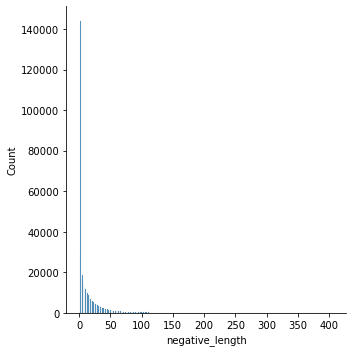

In [20]:
sns.displot(final_df['negative_length'])

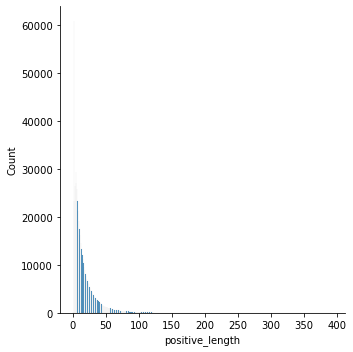

In [21]:
sns.displot(final_df['positive_length'])

In [22]:
final_df['positive_length'].describe()

count    515673.000000
mean         16.466718
std          21.463086
min           0.000000
25%           4.000000
50%          10.000000
75%          21.000000
max         393.000000
Name: positive_length, dtype: float64

In [23]:
final_df['negative_length'].describe()

count    515673.000000
mean         17.846649
std          29.050175
min           0.000000
25%           2.000000
50%           7.000000
75%          22.000000
max         406.000000
Name: negative_length, dtype: float64

Intuitivelly, we can consider short reviews as totally useless because they are not properly justified and they can misslead the model.

According to the median length, a reasonable guess will be to filter out reviews for which the length is smaller than the median.

In [24]:
positive_median = final_df['positive_length'].median()
negative_median = final_df['negative_length'].median()

In [25]:
final_df = final_df[(final_df['positive_length'] > positive_median) & (final_df['negative_length'] > negative_median) ]

In [26]:
final_df.shape

(126738, 7)

In [27]:
final_df.to_csv("cleaned_hotel_reviews.csv", sep='\t')

code sources:
* https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
* https://stackoverflow.com/questions/37084812/how-to-remove-decimal-points-in-pandas
* https://stackoverflow.com/questions/21291259/convert-floats-to-ints-in-pandas    